# Kennard-Stone Algorithm
The Kennard-Stone algorithm was first described in 1969 ([R. W. Kennard, L. A. Stone, *Technometrics*, **1969**,
*11*, 137–148.](https://www.tandfonline.com/doi/abs/10.1080/00401706.1969.10490666)) to select a diverse subset based on distance. 

## Imports & Settings

In [1]:
### Imports
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Add the utils directory to the path
sys.path.append(os.path.abspath("../utils"))

from chem import KennardStone

In [3]:
np.set_printoptions(precision=2)

# Data
The chemical structures of BRD4 inhibitors are encoded in bit vectors. For this data set **Morgan fingerprints** `rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect` was used. 






In [4]:
### Load the data
df = pd.read_pickle("data/morgan_2048_df.pkl")
df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
ID,,,,,,,,,,,,,,,,,,,,,
CHEMBL1232461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1233528,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1313432,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1344420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1361699,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL5440963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For visualization the 2048 Morgan fingerprints have been reduced two features using `sklearn.manifold.TSNE`. 

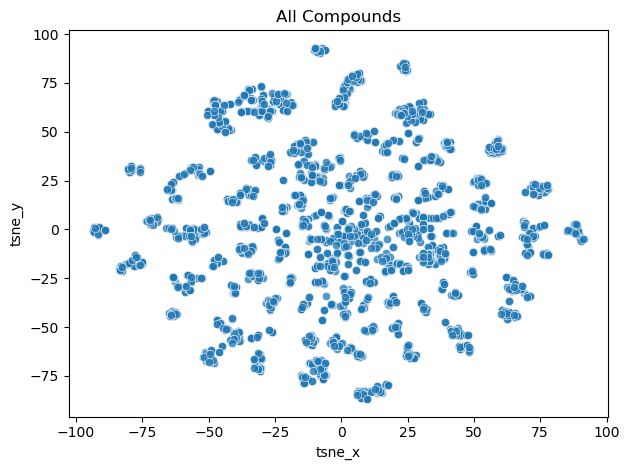

In [18]:
### Loading the results from Butina clustering 
butina_df = pd.read_pickle('data/butina_clusters_66.pkl')

### Plotting all compounds
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    data=butina_df,
    alpha=0.75,
)

plt.title("All Compounds")
plt.tight_layout()
plt.show()

# Method
The Kennard-Stone algorithm is of sequential nature. Meaning that one sample (or compound) at a time is added to the subset in an iterative manner. 

**The next compound added is the one with the maximum distance to its nearest neighbor already assigned to the subset.** 

The plot below illustrates the principal:

1) The red points are selected first to the subset as they are the furthest apart  `subset_count = 2`
2) The green point is added to the subset next. Of all non-red points it has the furthest distance to its nearest red neighbor. `subset_count = 3`
3) The blue point is added to the subset next following the same MinMax principal. `subset_count = 4`
4) This process is continued until the desired `subset_count` is reached. 

<img src="images/kennard_stone_exp.svg" alt="KennardStone" width="400">

This simple illustration already shows that
- Kennard-Stone selects singletons and edge cases rather than representative samples. 
- The feature (or chemical) space of the original data set is covered well even with small subsets.  

## Distance Matrix
Euclidean distance will be used. Between two vectors **x** and **y** in an n-dimensional space it is defined as:

$$
\text{Euclidean dist}(x, y) = \sqrt{ \sum_{i=1}^{n} (x_i - y_i)^2 }
$$

For small data sets it can be calculated by broadcasting in an additional dimension. 

In [5]:
### Demo data (4 sample, 2 features)
demo_X = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
    ])

### Calculating the Euclidean distance matrix with broadcasting
np.sqrt(((demo_X[None,:,:] - demo_X[:,None,:])**2).sum(axis=-1))

array([[0.  , 1.  , 1.  , 1.41],
       [1.  , 0.  , 1.41, 1.  ],
       [1.  , 1.41, 0.  , 1.  ],
       [1.41, 1.  , 1.  , 0.  ]])

For **binary vectors** (such as Morgan fingerprints used here), the squared Euclidean distance simplifies to the **Hamming distance** — i.e., the number of positions where the vectors differ:

$$
 \sum_{i=1}^{n} (x_i - y_i)^2 = \sum_{i=1}^{n} x_i + \sum_{i=1}^{n} y_i - 2 \sum_{i=1}^{n} x_i y_i
$$
Where:

- $ \sum_{i=1}^{n} x_i $ is the number of 1s in **x**
- $ \sum_{i=1}^{n} y_i $ is the number of 1s in **y**
- $ \sum_{i=1}^{n} x_i y_i $ is the number of **shared 1s** (intersection)

Computing the distance matrix using this method is more efficient for high-dimensional distance matrixes with a large number of samples and features. 


In [6]:
### Calculate the intersection matrix
intersection = demo_X @ demo_X.T

### Count the number of 1s for each compound
X_norm = demo_X.sum(axis=1).reshape(-1, 1)

### Calculate the Hamming distance matrix
hamming = X_norm + X_norm.T - 2 * intersection

### Euclidean distance
np.sqrt(hamming)

array([[0.  , 1.  , 1.  , 1.41],
       [1.  , 0.  , 1.41, 1.  ],
       [1.  , 1.41, 0.  , 1.  ],
       [1.41, 1.  , 1.  , 0.  ]])

## Applicability
**Limitations**

Although this algorithm can be used to perform data set splitting for machine learning, the resulting test set covers the same feature space as the training set. On one hand, this maximizes the feature space covered by the training set. On the other hand, the test scores do not represent a realistic scenario for prediction. 

**Diversity Set**

Due to the deterministic nature of the Kennard-Stone algorithm it is very useful to create a so-called diversity set. For example to reduce the number of molecules selected for synthesis to fit capacity while maintaining the distribution of the original set.  

# `KennardStone` Utility Class
The algorithm is defined in [utils/chem.py](utils/chem.py) as a class containing the methods to perform Kennard-Stone splitting. 


| Method        | Function Type           | Description                                           |
|---------------|-------------------------|-------------------------------------------------------|
| `__init__()`  | Constructor             | Initializes the class.       |
| `fit()`       | Public                  | Computes the distance matrix and assigns it as class attribute. |
| `split()`     | Public                  | Applies the Kennard-Stone algorithm to select a subset based on MinMax distances. |
| `_init_subset_mask()` | Helper          | Selects the first compound for the subset when `warm_start = False`. <br>Assigns `warm_subset` as selected when `warm_start = True` |

Class attributes are

| Attribute         | Type         | Description                                       |
|-------------------|--------------|---------------------------------------------------|
| `df`              | pd.DataFrame | Input data: binary fingerprints with unique index |
| `distance_matrix` | pd.DataFrame | Distance matrix (symmetrical)                     |
| `subset_mask`     | pd.DataFrame | Boolean mask for selected subset.                 |




# Demonstrative example
Generating a diversity set using the [`KennardStone`](../utils/chem.py) class. 

In [7]:
### Instantiate and fit the model
model = KennardStone().fit(df)

In [8]:
### Split the data
kennard_stone_subset = model.split(subset_size=0.10)
kennard_stone_subset

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
ID,,,,,,,,,,,,,,,,,,,,,
CHEMBL1233528,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1381011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
CHEMBL1480862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
CHEMBL1507539,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1698814,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL5432981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL5434041,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
CHEMBL5434208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Diversity Set 
## Kennard-Stone `or` Butina Clustering
The Kennard-Stone algorithm is very useful for subsetting an existing set of molecules to a smaller set with a similar distribution, a so-called *diversity set* covering the same chemical space of the original set. Such a diversity set can also be generated by selecting the centroids obtained from [Butina clustering](Butina.ipynb) assuming that the centroid is representative for the respective cluster. 

In the following analysis two diversity sets of equal size (10% of the original data set) were generated using **Butina clustering** and **Kennard-Stone** splitting as described above. In both cases the same Morgan fingerprints (2048 bit) were used as input features and the same coordinates (obtained from tSNE dimensionality reduction) are used for visualization. 

The scatterplot shows that the *Butina subset* is located primarily in the periphery of the tSNE plot. The *Kennard-Stone subset* on the other hand is clustered closer around the origin. It is not surprising that the overlap between both subsets (12 compounds or 5%) is minimal. The fact that 132 (or 55%) of the *Kennard-Stone subset* are classified as *Butina singletons* (non-cluster members) demonstrates the fundamental difference in the two approaches: *Kennard-Stone splitting* covers the given chemical space best by selecting all edge cases. Whereas, *Butina clustering* provides the most representative members (the centroids) of the largest clusters. 

When inspecting diversity sets visually (not shown in this repository) it feels like Kennard-Stone selects all *freak compounds* and Butina selects one example from each series. On the other hand, Kennard-Stone represents the chemical space much better.  

In [ ]:
### Use the same subset size
subset_size = len(kennard_stone_subset)

### Subsetting for the top cluster centroids
butina_subset_ids = butina_df.loc[butina_df['Centroid']].copy().sort_values(by='Cluster').head(subset_size).index

### Create a boolean subset column
butina_df['Subset'] = False
butina_df.loc[butina_subset_ids, 'Subset'] = True

butina_df

,Cluster,Centroid,Singleton,tsne_x,tsne_y,Subset
ID,,,,,,
CHEMBL1232461,372,True,True,25.143593,49.587025,False
CHEMBL1233528,373,True,True,-38.321075,-57.251869,False
CHEMBL1313432,374,True,True,12.222116,-8.992769,False
CHEMBL1344420,89,False,False,-7.628333,-66.965744,False
CHEMBL1361699,375,True,True,11.197386,15.300112,False
...,...,...,...,...,...,...
CHEMBL5440963,0,False,False,22.612637,58.660271,False
CHEMBL848,1115,True,True,-1.587567,-11.965448,False
CHEMBL9,1116,True,True,3.198491,-3.171075,False


In [10]:
### Using pre-computed t-SNE coordinates
kennard_stone_df = butina_df[['tsne_x', 'tsne_y']].copy()

### Boolean subset column
kennard_stone_df['Subset'] = kennard_stone_df.index.isin(kennard_stone_subset.index)

kennard_stone_df

,tsne_x,tsne_y,Subset
ID,,,
CHEMBL1232461,25.143593,49.587025,False
CHEMBL1233528,-38.321075,-57.251869,True
CHEMBL1313432,12.222116,-8.992769,False
CHEMBL1344420,-7.628333,-66.965744,False
CHEMBL1361699,11.197386,15.300112,False
...,...,...,...
CHEMBL5440963,22.612637,58.660271,False
CHEMBL848,-1.587567,-11.965448,False
CHEMBL9,3.198491,-3.171075,True


239 compounds (10.0% of the total data set) are in each subset
12 compounds (5.0% of one subset) are in both subsets
132 compounds (55.2% of one subset) in the Kennard-Stone subset are Butina singletons


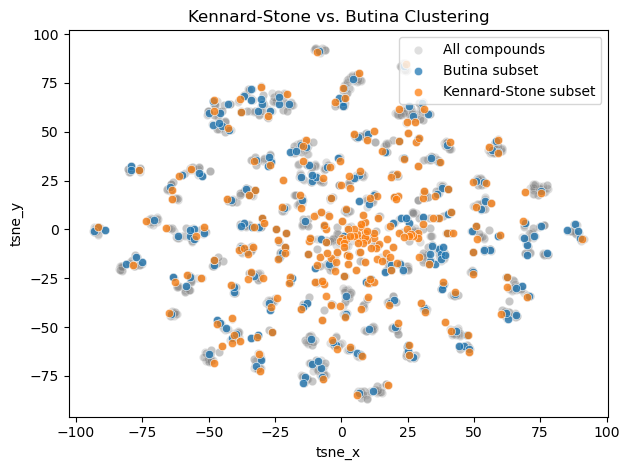

In [11]:
### Analyzis
overlap = butina_df.loc[butina_df['Subset']].index.isin(kennard_stone_df.loc[kennard_stone_df['Subset']].index).sum()
singletons = butina_df.loc[butina_df['Singleton']].index.isin(kennard_stone_df.loc[kennard_stone_df['Subset']].index).sum()

print(f"{subset_size} compounds ({subset_size/len(butina_df):.1%} of the total data set) are in each subset")
print(f"{overlap} compounds ({overlap/subset_size:.1%} of one subset) are in both subsets")
print(f"{singletons} compounds ({singletons/subset_size:.1%} of one subset) in the Kennard-Stone subset are Butina singletons")

### Plotting all compounds
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    data=butina_df,
    label="All compounds",
    color="gray",
    alpha=0.25,
)

### Plotting the subset from Butina clustering
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    data=butina_df.loc[butina_df['Subset']],
    label="Butina subset",
    alpha=0.75,
)

### Plotting the subset from Kennard-Stone splitting
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    data=kennard_stone_df.loc[kennard_stone_df['Subset']],
    label="Kennard-Stone subset",
    alpha=0.75,
)

plt.title("Kennard-Stone vs. Butina Clustering")
plt.tight_layout()
plt.show()

## Kennard-Stone `and` Butina Clustering

Due to the sequential nature of the Kennard-Stone algorithm it can start from a predefined subset obtained in a different manner. This is implemented as *warm_start* in [`KennardStone`](../utils/chem.py). Here the *Butina subset* of 239 (10%) compounds is extended to 359 (15%) by using the Kennard-Stone algorithm utilizing the advantages of both algorithms when generating one subset. The tSNE plot shows a good coverage of the chemical space defined by the original set. 

In [ ]:
### Instantiate and fit the model
mixed_model = KennardStone().fit(df)

In [13]:
### Use the Butina subset as starting point
butina_subset_ids

Index(['CHEMBL3769755', 'CHEMBL3753333', 'CHEMBL5200542', 'CHEMBL5403358',
       'CHEMBL4552460', 'CHEMBL4753402', 'CHEMBL3962757', 'CHEMBL4573400',
       'CHEMBL3650938', 'CHEMBL5269273',
       ...
       'CHEMBL1481742', 'CHEMBL1738926', 'CHEMBL2094636', 'CHEMBL2181703',
       'CHEMBL2181713', 'CHEMBL2181717', 'CHEMBL2181726', 'CHEMBL2181738',
       'CHEMBL2349346', 'CHEMBL2349362'],
      dtype='object', name='ID', length=239)

In [ ]:
### Split the data
mixed_subset = mixed_model.split(
    subset_size=0.15,
    warm_start=True, 
    warm_subset=butina_subset_ids
    )

359 compounds (15.0% of the total data set) are in the subset


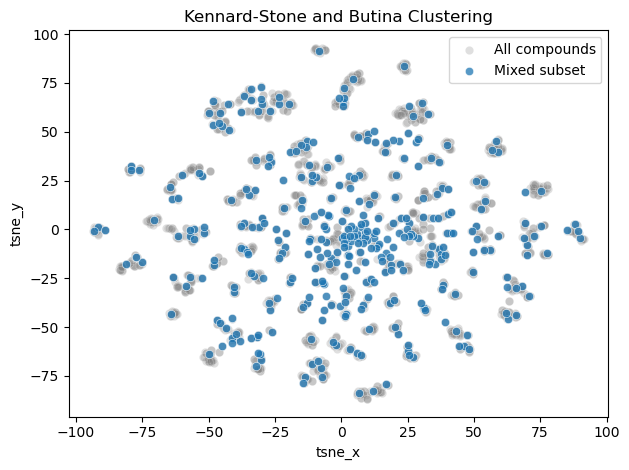

In [15]:
print(f"{len(mixed_subset)} compounds ({len(mixed_subset)/len(butina_df):.1%} of the total data set) are in the subset")

### Plotting all compounds
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    data=butina_df,
    label="All compounds",
    color="gray",
    alpha=0.25,
)

### Plotting the subset from Butina clustering
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    data=butina_df.loc[mixed_subset.index],
    label="Mixed subset",
    alpha=0.75,
)

plt.title("Kennard-Stone and Butina Clustering")
plt.tight_layout()
plt.show()

# Kennard-Stone and tSNE

To demonstrate the counterintuitive behavior of tSNE to plot singletons close to the origin and large clusters towards the periphery (see [Butina Clustering](Butina.ipynb)) two *Kennard-Stone diversity sets* will be generated. 
- The features for the first one are the 2048 Morgan Fingerprints also used as input for tSNE dimensionality reduction.
- The second one will use the tSNE output (two dimensions). 

As seen before both plots cover the feature space of the original data set well even where `subset_size = 0.05`. Using Morgan fingerprints as input results in a denser coverage around the origin. Using the tSNE coordinates as input ,however, results in a very even coverage of the chemical space. This demonstrates that the nature of the molecular descriptors used very much affects the data splitting.  

In [45]:
### Instantiate and fit the model
model_2048 = KennardStone().fit(df)

### Define the relative size of the diversity set
tsne_subset_size = 0.05

### Data splitting
morgan_subset = model_2048.split(subset_size=tsne_subset_size)


Because the utility class [`KennardStone.fit()`](../utils/chem.py) requires binary features the distance matrix needs to be provided when using the tSNE features. 

In [46]:
### Instantiate and fit the model
model_2 = KennardStone()

### tSNE features as NumPy array
X_tsne = butina_df[['tsne_x', 'tsne_y']].to_numpy()

### Calculating the Euclidean distance matrix with broadcasting
dist_matrix_np = np.sqrt(((X_tsne[None,:,:] - X_tsne[:,None,:])**2).sum(axis=-1))

###
model_2.distance_matrix = pd.DataFrame(dist_matrix_np, index=butina_df.index, columns=butina_df.index)

### Add input data to utility class
model_2.df = df

### Data splitting
tsne_subset = model_2.split(subset_size=tsne_subset_size)

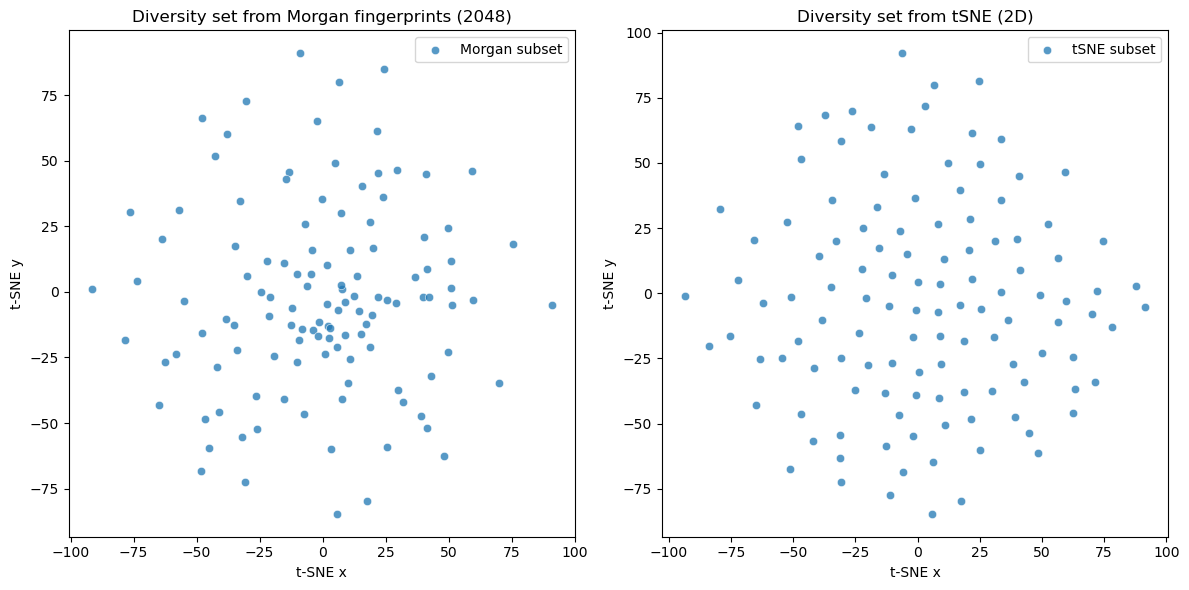

In [48]:
### Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()  # flatten for easier indexing

### Plotting the subset from Kennard-Stone splitting
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    data=butina_df.loc[morgan_subset.index],
    label="Morgan subset",
    alpha=0.75,
    ax=axes[0]
)
axes[0].set_title('Diversity set from Morgan fingerprints (2048)')
axes[0].set_xlabel("t-SNE x")
axes[0].set_ylabel("t-SNE y")

### Plotting the subset from Butina clustering
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    data=butina_df.loc[tsne_subset.index],
    label="tSNE subset",
    alpha=0.75,
    ax=axes[1]
)
axes[1].set_title('Diversity set from tSNE (2D)')
axes[1].set_xlabel("t-SNE x")
axes[1].set_ylabel("t-SNE y")

plt.tight_layout()
plt.show()